In [1]:

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np
from shapely import wkt

from business_models import hahn, greenplum

import pandas as pd

from shapely.geometry import Point,Polygon

from shapely.geometry import shape, GeometryCollection

import folium

import numpy as np
import geopandas as gpd


import time

from matplotlib import pyplot as plt

import ipywidgets as widgets

from IPython.display import clear_output


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [234]:


def receive_dict_cte_hex(hex_gid, ext_id,speed, service_time):
    
    df_dist = greenplum('select * from analyst.iat_hex_cross_distance where external_id_left=\'{}\''.format(ext_id))
    print(hex_gid)
    df_dist_hex = df_dist[(df_dist.hex_gid_x==hex_gid)]
    print('проверка - размер лавки',df_dist_hex.shape)
    df_dist_hex['cte_hex'] = (df_dist['dist']+100)*speed/1000 + service_time
    dict_cte_hex = dict(zip(df_dist_hex['hex_gid_y'],df_dist_hex['cte_hex']))
#     print(dict_cte_hex)
    return dict_cte_hex

def receive_dict_c1c2_hex(ext_id,col2weight='C12_res_hex'):
    df_socdem = greenplum('select * from analyst.iat_hex_main_metrics_cte_may where external_id=\'{}\''.format(ext_id))
    dict_c1c2 = dict(zip(df_socdem['hex_gid'],df_socdem[col2weight]))
    return dict_c1c2

def transform_gdf(df, geometry):
    
    try:
        df[geometry]=df[geometry].apply(lambda x: None if pd.isnull(x)or x =='None' else wkt.loads(x))
    except:
        pass
    
    gdf =gf.get_gdf(df, geometry, 4326)
    
    return gdf

def receive_cte_fact(ext_id):
    
    df = greenplum('select count_orders, cte_mean, "C12_res_hex" from analyst.iat_hex_main_metrics_cte_may where external_id=\'{}\''.format(ext_id))
    cte_wgt_order = round((df['cte_mean']*df['count_orders']).sum()/df['count_orders'].sum()/60,2)
    cte_wgt_c1c2 = round((df['cte_mean']*df['C12_res_hex']).sum()/df['C12_res_hex'].sum()/60,2) 
    
#     print('cor',df[['C12_res_hex','count_orders']].corr())
    
    
    
    plt.scatter(df['cte_mean'],df['count_orders'])
    plt.title('cte mean vs count_orders')
    plt.xlabel('cte_mean')
    plt.show()
    
    plt.scatter(df['cte_mean'],df['C12_res_hex'])
    plt.title('cte mean vs C1C2')
    plt.xlabel('cte_mean')
    plt.show()
    
    n=min(df.shape[0]//10,7)
    
    df.groupby(pd.qcut(df['C12_res_hex'], q=n, duplicates='drop'))['cte_mean'].mean().plot(kind='bar')
    plt.show()
    
    
    plt.scatter(df['count_orders'],df['C12_res_hex'])
    plt.title('count orders vs C1C2')
    plt.xlabel('count orders')
    
    plt.show()
    
    dict_lavki_cte[ext_id]={'cte_wgt_order':cte_wgt_order,'cte_wgt_c1c2':cte_wgt_c1c2}
    
    print('cte fact -  {},  cte of current location weighted on C1C2 - {}'.format(*list(dict_lavki_cte[ext_id].values())))

def receive_lavki():
    df_lavki = greenplum("""select t1.* from analyst.iat_lavki_zones_monthly t1

                            where dt='2021-06-15'
                            and cluster = 'Москва'
                            and status='active'
                            and t1.external_id in (select text(external_id) from analyst.iat_hex_main_metrics_cte_may)""")
#     lavki_list = df_lavki
    
    return df_lavki

def receive_ext_id(lavka_title):
    return df_lavki[df_lavki.title==lavka_title]['external_id'].iloc[0]

def receive_hex_list(ext_id):
    
    df_hex_list = greenplum('select hex_name, hex_gid from analyst.iat_hex_main_metrics_cte_may where external_id=\'{}\''.format(ext_id))
#     lavki_list = df_lavki
    dict_hex_id_name[ext_id] = dict(zip(df_hex_list['hex_name'],df_hex_list['hex_gid']))
    
    return df_hex_list.hex_name.unique(), dict_hex_id_name


def receive_store(ext_id):
    df_store = greenplum('select * from analyst.iat_lavka_stores_monthly where external_id=\'{}\''.format(ext_id))
#     lavki_list = df_lavki
    
    return df_store


In [222]:
def receive_sample():
    df = greenplum('select * from analyst.iat_hex_main_metrics_cte_may where external_id=\'{}\''.format(ext_id))
    print(df.shape)
    gdf_hex  = greenplum("select * from analyst.iat_hex_tbl where city='moscow' ")
    gdf_hex['geometry']=gdf_hex['geometry'].apply(lambda x: wkt.loads(x))
    
    gdf = df.merge(gdf_hex, on='hex_gid', how='inner')
    
    gdf_transf = transform_gdf(gdf, 'geometry')
    return gdf_transf

In [185]:
def show_map(ext_id, hex_name_list):
    
    gdf_lavka_hex = receive_sample()
    
    gdf_lavka_hex['cte_min_prc']= gdf_lavka_hex['count_orders'].apply(lambda x:1 if x>5 else None)* gdf_lavka_hex['cte_min']
#     print('check ', gdf_lavka_hex.shape)
    
    hex_gid_list = gdf_lavka_hex['hex_gid'].unique().tolist()
    
    gdf_lavki_zone = df_lavki[df_lavki.external_id==ext_id]
    
    gdf_lavki_zone = transform_gdf(gdf_lavki_zone, 'geometry_zone')

    gdf_hex_lavki_stores = receive_store(ext_id)
    
    gdf_hex_lavki_stores = transform_gdf(gdf_hex_lavki_stores, 'location_str')

    col = 'geometry_store'
#     gdf_hex_lavki_stores[col] = gdf_hex_lavki_stores[col].apply(lambda x: None if pd.isnull(x) else wkt.loads(x))
#     gdf_hex_lavki_stores =gf.get_gdf(gdf_hex_lavki_stores,
#             col,
#                              4326,


    x = gdf_lavki_zone.geometry_zone.iloc[0].centroid.x 
    y = gdf_lavki_zone.geometry_zone.iloc[0].centroid.y
    
    m1 = folium.Map([y,x], zoom_start=13, attr='My Data Attribution')
  
#     print(gdf_lavka_hex.head()['cte_min'])
    transparetn_style = lambda feature: {'fillColor': 'gray','color': 'gray','weight': 0,'fillOpacity':0.00}

    # c1c2 
   
    
#     exterdf_lavka_hex['hex_gid'].unique().tolist()
    
    df_lavka_externalid = ext_id
    
    bin_size_15m = min(6,max(3, int(gdf_lavka_hex['C12_res_15m'].max()//1500)+1))
    folium.Choropleth(geo_data= gdf_lavka_hex [['hex_gid','geometry']],
                 data= gdf_lavka_hex ,
                 name='C1C2 жители с cte 15-18 min',
                 columns=['hex_gid','C12_res_15m'],
                 key_on='feature.properties.hex_gid',
                 method='equal',
                 bins=bin_size_15m,
    #            bins=bins,
                 fill_color='Reds', fill_opacity=0.7, line_opacity=0,
                 legend_name='C1C2_cte15',
                 show=False,
    #                  popup_hover = 'count_orders_hex_day'
    #                  ,tooltip=html
    #              highlight=True
                ).add_to(m1)
    
    folium.Choropleth(geo_data= gdf_lavka_hex [['hex_gid','geometry']],
                 data= gdf_lavka_hex ,
                 name='C1C2 жители',
                 columns=['hex_gid','C12_res_hex'],
                 key_on='feature.properties.hex_gid',
                 method='quantile',
                 bins=3,
    #                  bins=bins,
                 fill_color='Reds', fill_opacity=0.7, line_opacity=0,
                 legend_name='C1C2_hex',
                 show=False,
    #                  popup_hover = 'count_orders_hex_day'
    #                  ,tooltip=html
    #              highlight=True
                ).add_to(m1)
    
    folium.Choropleth(geo_data= gdf_lavka_hex [['hex_gid','geometry']],
                 data= gdf_lavka_hex ,
                 name='num of orders',
                 columns=['hex_gid','count_orders'],
                 key_on='feature.properties.hex_gid',
#                  method='quantile',
                 bins=4,
    #                  bins=bins,
                 fill_color='Greens', fill_opacity=0.7, line_opacity=0,
                 legend_name='num of orders',
                 show=False,
    #                  popup_hover = 'count_orders_hex_day'
    #                  ,tooltip=html
    #              highlight=True
                ).add_to(m1)
    
    bin_size = max(3,int(gdf_lavka_hex['cte_min_prc'].max()//15+1))
    folium.Choropleth(geo_data=gdf_lavka_hex [['hex_gid','geometry','cte_min']],
                 data= gdf_lavka_hex[['hex_gid','cte_min_prc']] ,
                 name='cte_min',
                 columns=['hex_gid','cte_min_prc'],
                 key_on='feature.properties.hex_gid',
                 method='equal',
                 bins=bin_size,
        #                  bins=bins,
                 fill_color='PuOr', fill_opacity=0.7, line_opacity=0,
       legend_name='cte minutes',
                 show=True
                ).add_to(m1)

    layer_lavka_zones = folium.GeoJson(
        gdf_lavki_zone[gdf_lavki_zone.external_id==ext_id],
        show=True,
        name='lavki zones',
        style_function=lambda feature: {
            'color' : 'blue',
            'weight' : 4,
            'fillOpacity' : 0.0,
            },
        tooltip=folium.features.GeoJsonTooltip(
                    fields=['address'
                           ],
                    aliases=['Лавка:'
                          ],
                    style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
        )
        ).add_to(m1)
    
    #cte
    

    layer_lavka_store = folium.GeoJson(
    gdf_hex_lavki_stores[gdf_hex_lavki_stores.external_id==ext_id][['location_str','address','external_id']],
    name='lavka stores',
    show=True,
    style_function=lambda feature: {
        'color' : 'blue',
        'weight' : 3,
        'fillOpacity' : 0.0,
        },
     tooltip=folium.features.GeoJsonTooltip(
                fields=['address','external_id'
                       ],
                aliases=['address','id',
                      ],
                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
).add_to(m1)
    
    layer_hexes = folium.GeoJson(
    gdf_lavka_hex [['geometry','hex_name']],
    name='hex_names',
    show=True,
    style_function=lambda feature: {
        
        'weight' : 0,
        'fillOpacity' : 0.0,
        },
     tooltip=folium.features.GeoJsonTooltip(
                fields=['hex_name'
                       ],
                aliases=['hex'
                      ],
                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
).add_to(m1)
    folium.LayerControl(collapsed=False).add_to(m1)
    return m1

In [ ]:
# сейчас 

# хочется понять для кого мы улучшаем  сte - это один гекс или равномерно для всех

# хочется увидеть улучшение дельту

Загружаем лавки и задаем базовые параметры : время диспатча и сборки+ скорость 

In [231]:
df_lavki = receive_lavki()
lavki_list = sorted(df_lavki['title'].unique())


hex_name_list =[]
ext_id=''
dict_hex_dists=dict()# hex_id  и все пары гекс - cte
dict_hex_c1c2=dict()
service_time = 9# мин
speed = 7 # мин/км
col_weighted='C12_res_hex'
dict_hex_id_name=dict()
dict_lavki_cte_calc = dict()
dict_lavki_cte=dict()

Выбираем лавку. Каждая следующая выбранная лавка отображается ниже ( не перерисовывается), cte-fact - cte мая взвешенный на число заказов, cte-C1C2 - cte мая взвешенный на население c1c2

Dropdown(description='Лавка', options=('1-й переулок Тружеников, 14с5', '1905 года, 10Ас1', '2-я Владимирская,…

245674


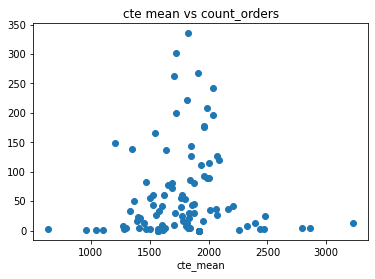

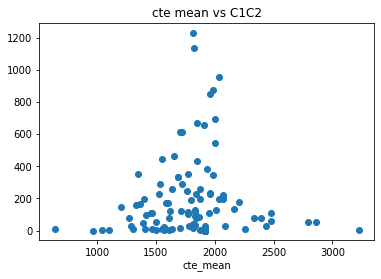

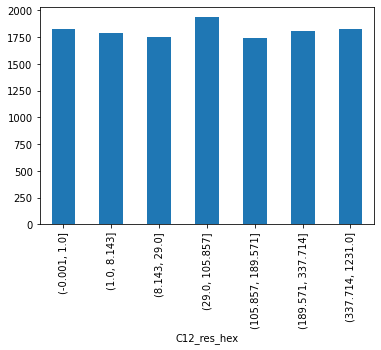

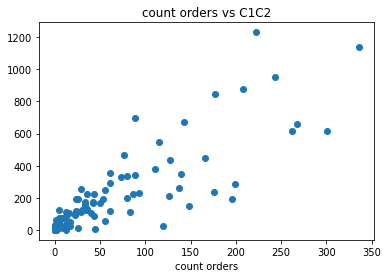

cte fact -  30.12,  cte of current location weighted on C1C2 - 30.45
(124, 25)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [246]:
selector_lavki = widgets.Dropdown(
    options=lavki_list,
    value=None,
    description='Лавка',
    disabled=False,
)

def lavka_handler(lavka):

    global hex_name_list
    global ext_id
    global dict_hex_id_name
    
    ext_id = receive_ext_id(lavka.new)
    print(ext_id)
    
    hex_name_list, dict_hex_id_name= receive_hex_list(ext_id)
    
    receive_cte_fact(ext_id)

    
    if ext_id not in dict_lavki_cte_calc.keys():
        dict_lavki_cte_calc[ext_id]=dict()
     
   
    global m1
    m1= show_map(ext_id, hex_name_list)
    
    display(m1)
        
    
lavka_chosen = selector_lavki.observe(lavka_handler,names='value')

display(selector_lavki)

In [ ]:
# расчетный cte* c1c2 до 
# и 
# расчетный cte* c1c2 после

Выбираем гекс, ориентируясь на гексы на карте, Для честности эксперимента правильно посчитать гекс на котором сейчас стоит лавка по той же логике, что и новые, cte-расчетный = сумма(( дистанция * *скорость+ время сборки)* * C1C2)/(сумма С1С2)

Dropdown(description='гексы лавки', options=('245674_1', '245674_10', '245674_101', '245674_103', '245674_104'…

8911aa0da47ffff
проверка - размер лавки (130, 9)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


19.56323195938341


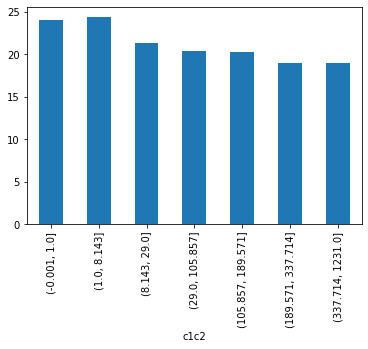

8911aa0daabffff
проверка - размер лавки (130, 9)
19.83566413182843


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


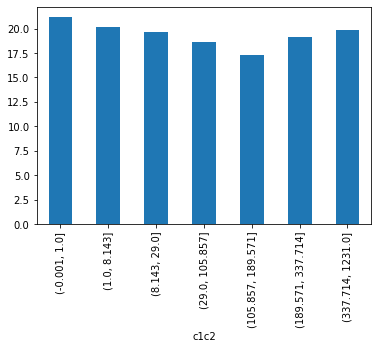

8911aa0da53ffff
проверка - размер лавки (130, 9)
20.2816840937487


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


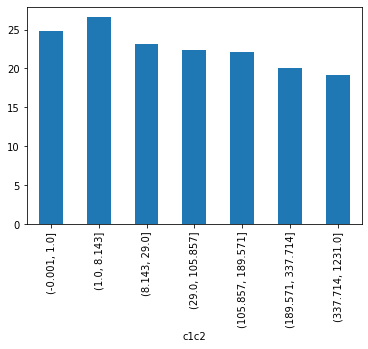

8911aa0da0fffff
проверка - размер лавки (130, 9)
19.142163784527785


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


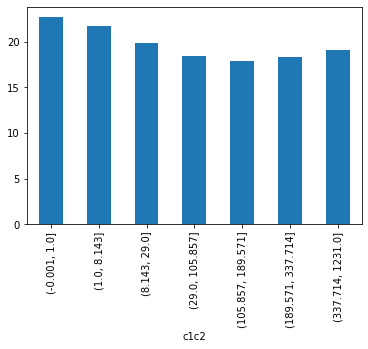

In [247]:
selector_hex = widgets.Dropdown(
    options=sorted(hex_name_list),
    value=None,
    description='гексы лавки',
    disabled=False,
)
 

def hex_handler(hex_id):# считалка нового cte

    global dict_hex_dists
    global dict_hex_с1с2
    global ext_id
    global col_weighted
    global service_time
    global speed
    
    hex_gid = dict_hex_id_name[ext_id][hex_id.new] # получаем hash гекса
    
    if hex_id.new not in dict_hex_dists.keys():
        dict_hex_dists[hex_id.new] = receive_dict_cte_hex(hex_gid,ext_id, speed, service_time)
    
    if ext_id not in dict_hex_c1c2.keys():
        dict_hex_c1c2[ext_id] = receive_dict_c1c2_hex(ext_id,col_weighted)
        
    df = pd.Series(dict_hex_c1c2[ext_id],name='c1c2').to_frame().\
    join(pd.Series(dict_hex_dists[hex_id.new],name='cte_calc'))
    
#     df['cte_calc']=(df['dist']+100)*speed/1000 + service_time
        
    new_cte = sum(df['cte_calc']*df['c1c2'])/sum(df['c1c2'])
    print(new_cte)
    
    n=min(df.shape[0]//10,7)
    
    df.groupby(pd.qcut(df['c1c2'], q=n, duplicates='drop'))['cte_calc'].mean().plot(kind='bar')
    plt.show()
    
    
    dict_lavki_cte_calc[ext_id][hex_id.new]=new_cte
    
    
    
       
hex_chosen = selector_hex.observe(hex_handler,names='value')
display(selector_hex)

In [ ]:
# добавить распределение, делать сравнение распределений

# график cte - кол-во заказов, ,было -стало на карте
# закрасить белым число заказов меньше n

In [ ]:
# с1с2 против дистанции было

# с1с2 против сte было

# с1c2 против 